The code for the VQ-VAE is taken from https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb

In [1]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid


from sklearn.model_selection import train_test_split

from fid import *

/Users/sayansuos/Library/CloudStorage/OneDrive-Personnel/Documents/ENSAI/3A/Projet de fin d'études/3A-pfe/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print("Device:", device)

# User configurable: Set to True for RGB input (3 channels), False for Grayscale (1 channel)
use_rgb_input = True

Device: mps


In [3]:
np.random.seed(0)
torch.manual_seed(0)

# Data

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types")

print("Path to dataset files:", path)

Path to dataset files: /Users/sayansuos/.cache/kagglehub/datasets/vishalsubbiah/pokemon-images-and-types/versions/4


In [5]:
from PIL import Image
import os
from pathlib import Path
import kagglehub

# 1. Utiliser kagglehub pour avoir le chemin correct automatiquement
# (Cela évite les erreurs de version "v4" vs "v5")
base_path = Path(kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types"))
output_folder = Path("./data/pokemon_images_256")
output_folder.mkdir(parents=True, exist_ok=True)

size = (256, 256)
valid_exts = {".png", ".jpg", ".jpeg", ".webp"}
count = 0

# 2. On scanne TOUS les sous-dossiers pour être sûr de trouver les images
print(f"Recherche dans : {base_path}")

for img_path in base_path.rglob("*"):
    if img_path.suffix.lower() in valid_exts:
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(size, Image.LANCZOS)

            # 3. IMPORTANT : on met tout en minuscules pour correspondre au CSV
            out_name = img_path.stem.lower() + ".jpg"
            img.save(output_folder / out_name, "JPEG", quality=95)

            count += 1

        except Exception as e:
            print(f"Erreur avec {img_path}: {e}")

print(f"{count} images redimensionnées et sauvegardées dans {output_folder}")

Recherche dans : /Users/sayansuos/.cache/kagglehub/datasets/vishalsubbiah/pokemon-images-and-types/versions/4
809 images redimensionnées et sauvegardées dans data/pokemon_images_256


In [6]:
path = kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types")
csv_path = os.path.join(path, "pokemon.csv")

df = pd.read_csv(csv_path)
df.head()


,Name,Type1,Type2,Evolution
0,bulbasaur,Grass,Poison,ivysaur
1,ivysaur,Grass,Poison,venusaur
2,venusaur,Grass,Poison,NaN
3,charmander,Fire,NaN,charmeleon
4,charmeleon,Fire,NaN,charizard


In [7]:
training_df, validation_df = train_test_split(
    df,
    test_size=0.1,
    random_state=0,
    shuffle=True
)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform
        self.classes = sorted(self.data["Type1"].unique())

        if isinstance(self.data.iloc[0]["Type1"], str):
            classes = sorted(self.data["Type1"].unique())
            self.label_to_idx = {c: i for i, c in enumerate(classes)}
        else:
            self.label_to_idx = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        name = row["Name"]

        img_path = os.path.join(self.image_dir, name) + ".jpg"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        label = row["Type1"]
        if self.label_to_idx is not None:
            label = self.label_to_idx[label]

        return name, image, label


In [9]:
image_size = 128

training_data = CustomDataset(
    data=training_df,
    image_dir=output_folder,
    transform=transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
        ])
)
validation_data = CustomDataset(
    data=validation_df,
    image_dir=output_folder,
    transform=transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
        ])
)

In [10]:
print(f"Nombre de données d'entrainement : {len(training_data)}")
print(f"Nombre de classes : {len(training_data.label_to_idx)}")
print(f"Classes : {training_data.label_to_idx}")

Nombre de données d'entrainement : 728
Nombre de classes : 18
Classes : {'Bug': 0, 'Dark': 1, 'Dragon': 2, 'Electric': 3, 'Fairy': 4, 'Fighting': 5, 'Fire': 6, 'Flying': 7, 'Ghost': 8, 'Grass': 9, 'Ground': 10, 'Ice': 11, 'Normal': 12, 'Poison': 13, 'Psychic': 14, 'Rock': 15, 'Steel': 16, 'Water': 17}


In [11]:
loader = DataLoader(training_data, batch_size=128, shuffle=False)

sum_ = 0.0
sum_sq = 0.0
num_pixels = 0

for _, imgs, _ in loader:
    num_pixels += imgs.numel()
    sum_ += imgs.sum().item()
    sum_sq += (imgs ** 2).sum().item()

mean = sum_ / num_pixels
data_variance = sum_sq / num_pixels - mean ** 2


# VQ

In [12]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim   # Taille des embeddings
        self._num_embeddings = num_embeddings # Nombre d'embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim) # Dictionnaire qui contient tous les vecteurs
        self._embedding.weight.data.normal_() # On le remplit d'abord de v.a.
        self._commitment_cost = commitment_cost # Punit l'encodeur s'il s'éloigne trop d'une valeur existante

        # Ici, pcq on utilise par une GD, mais une EMA (moyenne mobile)
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings)) # Garde en mémoire cb de fois le vecteur a été choisi par le modèle
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim)) # Pour conserver les changements de poids sur les vecteurs
        self._ema_w.data.normal_()

        self._decay = decay # Force de la mémoire, souvent = 99% i.e. 1% de 'nouveauté' acceptée
        self._epsilon = epsilon  # Pour éviter de diviser par 0 si un vecteur n'est jamais choisi

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC = Batch Height Width Channel
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input: on écrase BHW en une colonne
        flat_input = inputs.view(-1, self._embedding_dim) # = 1 zone de l'image

        # Calculate distances: dist entre chaque vecteur de l'image et chaque vecteur du dict des embeddings
        # Matrice ligne = point de l'image et colonne = vecteur du dictionnaire. Plus le chiffre est petit, plus ils se ressemblent.
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # on choisit la plus petite distance
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device) # on créé le one-hot vector
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten: on multiplie les one=hots vectors par les vecteurs du dict, et on redonne la bonne forme
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0) # On compte combien de fois chaque vecteur du dictionnaire a été choisi dans ce batch

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n) # aucun où un vecteur n'est jamais choisi

            dw = torch.matmul(encodings.t(), flat_input) # somme de tous les vecteurs réels de l'image qui ont "choisi" le vecteur i du dictionnaire
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw) # maj du poids moyen en utilisant encore le decay
            # calcul des vrais poids du dic : Moyenne = Somme des valeurs / Nombre d'utilisations
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # difference entre le vecteur de l'encodeur et le vecteur du dict choisi
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach() # detach() utilisé lorsqu'on ne veut pas que ce soit pris en compte lors du BACKWARD?
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10))) # indicateur qui dit si le modèle utilise bien tout son dictionnaire

        # convert quantized from BHWC -> BCHW

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [13]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False), # regarde les pixels voisins
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False) # regarde qu'un pixel
        )

    def forward(self, x):
        return x + self._block(x) # on passe l'info originale et les transformations à la couche suivante (raccourci)

# Pile de couches qui ajoute ce qu'elle vient d'apprendre à l'image d'origine au lieu de la remplacer
class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [14]:
class Encoder(nn.Module): # Résumer les informations de l'image dans un vecteur
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        # Réduit la taille par 2, et encore par 2 (cf. stride)
        # Mais l'image devient de + en + épaisse (out_channels) -> remplace les couleurs par des caractéristiques
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2, # Réduction de la taille
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        # Stabiliser les informations (cf. stride)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens, # Affine les infos de l'image
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [15]:
class Decoder(nn.Module): # Reconstruire l'image à partir du résumé d'information
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_output_channels=3):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1) # Juste histoire d'apprendre ?

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens) # Pour capturer les détails sans perdre l'information globale

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1) # Augmente la taille x 2

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_output_channels,
                                                kernel_size=4,
                                                stride=2, padding=1) # Augmente la taille x 2

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

# Train

In [ ]:
# A choisir selon la taille du données: 256 et 15000 un peu bcp pour les pokemons
batch_size = 32
num_training_updates = 15000

epochs = num_training_updates // (len(training_data) // batch_size)

num_hiddens = 128            # Puissance de calcul des convolutions
num_residual_hiddens = 32       # Pour le bloc résiduel
num_residual_layers = 2

embedding_dim = 128              # Taille des vecteurs dans le dictionnaire
num_embeddings = 64           # Nombre de vecteurs dans le dictionnaire -> à ajuster avec la perplexité

commitment_cost = 0.5      # Force l'encodeur à ne pas trop s'éloigner du dictionnaire -> mettre à 0.5 si le modèle converge pas

decay = 0.9

learning_rate = 1e-4

print("Iteration per epoch:", len(training_data) // batch_size)
print("Epoch:", epochs)

Iteration per epoch: 22
Epoch: 681


In [17]:
training_loader = DataLoader(training_data,
                               batch_size=batch_size,
                               shuffle=True,
                               pin_memory=True)

validation_loader = DataLoader(validation_data,
                               batch_size=batch_size,
                               shuffle=True,
                               pin_memory=True)

In [18]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay, num_input_channels=3, num_output_channels=3):
        super(Model, self).__init__()

        # Résumé compact de l'image
        self._encoder = Encoder(num_input_channels, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        # Adapter la taille entre l'encoder et le VQVAE
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        # Remplace le résumé par des vecteurs "propres" du dictionnaire
        self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                           commitment_cost, decay)
        # Image reconstruite
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens, num_output_channels=num_output_channels)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [19]:
num_input_channels = 3 if use_rgb_input else 1
num_output_channels = 3 if use_rgb_input else 1

model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay,
              num_input_channels=num_input_channels,
              num_output_channels=num_output_channels).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [20]:
from torchinfo import summary

# row_settings=["depth", "var_names"] permet de voir le nom de tes variables
summary(model, input_size=(batch_size, 3, image_size, image_size), row_settings=["depth", "var_names"])

Layer (type (var_name):depth-idx)                  Output Shape              Param #
Model (Model)                                      --                        --
├─Encoder (_encoder): 1-1                          [32, 128, 32, 32]         --
│    └─Conv2d (_conv_1): 2-1                       [32, 64, 64, 64]          3,136
│    └─Conv2d (_conv_2): 2-2                       [32, 128, 32, 32]         131,200
│    └─Conv2d (_conv_3): 2-3                       [32, 128, 32, 32]         147,584
│    └─ResidualStack (_residual_stack): 2-4        [32, 128, 32, 32]         --
│    │    └─ModuleList (_layers): 3-1              --                        81,920
├─Conv2d (_pre_vq_conv): 1-2                       [32, 64, 32, 32]          8,256
├─VectorQuantizerEMA (_vq_vae): 1-3                --                        16,384
├─Decoder (_decoder): 1-4                          [32, 3, 128, 128]         --
│    └─Conv2d (_conv_1): 2-5                       [32, 128, 32, 32]         73,856
│    └─

In [21]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

/Users/sayansuos/Library/CloudStorage/OneDrive-Personnel/Documents/ENSAI/3A/Projet de fin d'études/3A-pfe/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


50

Epoch 50
Recon Error Train (moy epoch): 0.075
Perplexity (moy epoch): 5.494
Learning rate (moy epoch): 0.000
Fréchet Inception Distance (FID): 276.4372


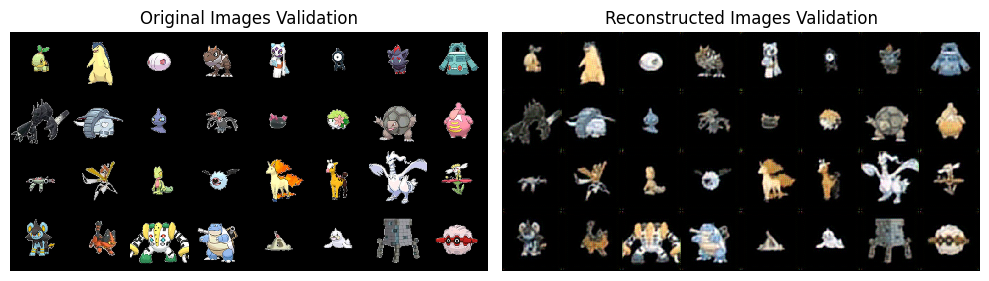

Recon Error Validation: 0.074
--- Nouveau record ! Modèle sauvegardé (Erreur: 0.0737) ---


KeyboardInterrupt: 

In [ ]:
train_res_recon_error = []
train_res_perplexity = []
train_lr = []
val_res_recon_error = []
fids = []

# Pour suivre le meilleur modèle
best_val_error = float('inf')

# Créer un dossier pour les sauvegardes si nécessaire
import os
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

for epoch in range(epochs):

    model.to(device)

    for i, (_, data, _) in enumerate(training_loader):
        iteration = epoch * (len(training_data) // batch_size) + i
        model.train()
        data = data.to(device)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(data)
        recon_error = F.mse_loss(data_recon, data) / data_variance

        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item()) 
        train_lr.append(optimizer.param_groups[0]['lr']) 

        if (epoch + 1) % 50 == 0 and (i+1) % len(training_loader) == 0:
            print(epoch+1)
            last_n = len(training_loader) 
            current_recon = np.mean(train_res_recon_error[-last_n:])
            current_perp = np.mean(train_res_perplexity[-last_n:])
            current_lr = np.mean(train_lr[-last_n:])
            
            print(f"\nEpoch {epoch+1}")
            print(f'Recon Error Train (moy epoch): {current_recon:.3f}')
            print(f'Perplexity (moy epoch): {current_perp:.3f}')
            print(f"Learning rate (moy epoch): {current_lr:.3f}")

            model.eval()
            (_, valid_originals, _) = next(iter(validation_loader))
            valid_originals = valid_originals.to(device)

            vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
            _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
            valid_reconstructions = model._decoder(valid_quantize)

            # Calcul du FID
            real_features = get_inception_features(valid_originals)
            gen_features = get_inception_features(valid_reconstructions)
            fid = calculate_fid(real_features, gen_features)
            fids.append(fid)
            print(f'Fréchet Inception Distance (FID): {fids[-1]:.4f}')

            # Display original and reconstructed images side-by-side
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            # Original images
            original_grid = make_grid(valid_originals.cpu() + 0.5).numpy()
            original_grid = np.clip(original_grid, 0, 1) # Ensure values are in [0, 1]
            axes[0].imshow(np.transpose(original_grid, (1, 2, 0)), interpolation='nearest')
            axes[0].set_title('Original Images Validation')
            axes[0].axis('off')

            # Reconstructed images
            recon_grid = make_grid(valid_reconstructions.cpu().data + 0.5).numpy()
            recon_grid = np.clip(recon_grid, 0, 1) # Ensure values are in [0, 1]
            axes[1].imshow(np.transpose(recon_grid, (1, 2, 0)), interpolation='nearest')
            axes[1].set_title('Reconstructed Images Validation')
            axes[1].axis('off')

            # POUR LA VALIDATION DATA
            with torch.no_grad(): # On ne calcule pas de gradients (gain de mémoire)
                (_, data_v, _) = next(iter(validation_loader))
                valid_originals = data_v.to(device)

                # On passe dans le modèle
                v_loss, data_v_recon, v_perp = model(valid_originals)

                v_recon_error = F.mse_loss(data_v_recon, valid_originals) / data_variance
                val_res_recon_error.append(v_recon_error.item())
                print(f'Recon Error Validation: {v_recon_error.item():.3f}')

            # --- SAUVEGARDE DU MEILLEUR MODÈLE ---
                if v_recon_error < best_val_error:
                    best_val_error = v_recon_error
                    torch.save(model.state_dict(), 'checkpoints/vqvae_pokemon_best.pth')
                    print(f"--- New record! Model saved (Error: {v_recon_error:.4f}) ---")
            
            plt.tight_layout()
            plt.show()
            model.train() # Set model back to train mode

print("Training over. Final saving...")

# 1. Sauvegarder le dernier état du modèle et de l'optimiseur
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_training_updates': num_training_updates,
    'recon_error': train_res_recon_error[-1],
}, 'checkpoints/vqvae_pokemon_final.pth')

# 2. Sauvegarder les courbes de metrics en CSV (pour les réutiliser dans Excel ou autre)
df_train = pd.DataFrame({
    'train_recon_error': train_res_recon_error,
    'train_perplexity': train_res_perplexity
})
df_train.to_csv('checkpoints/metrics_train_pokemon.csv', index=False)

# Pour la validation, on crée un axe X correspondant aux intervalles
val_step = 100 * len(training_loader) 
df_val = pd.DataFrame({
    'iteration': [ (j+1) * val_step for j in range(len(val_res_recon_error)) ],
    'val_recon_error': val_res_recon_error
})
df_val.to_csv('checkpoints/metrics_val_pokemon.csv', index=False)

print("Everything has been saved in the folder /checkpoints!")

# Loss

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 51, 3)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 51, 3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

val_interval_iterations = 100 * len(training_loader) 

f = plt.figure(figsize=(16, 8))

# --- GRAPHIQUE 1 : ERREUR DE RECONSTRUCTION (NMSE) ---
ax = f.add_subplot(1, 2, 1)
ax.plot(train_res_recon_error_smooth, label='Train (Smoothed)')

# Génération de l'axe X pour la validation
x_val = np.arange(len(val_res_recon_error)) * val_interval_iterations
ax.plot(x_val, val_res_recon_error, label='Validation', marker='o', linestyle='--')

ax.set_yscale('log') # Très important pour voir la convergence fine
ax.set_title('NMSE: Train vs Validation')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend()

# --- GRAPHIQUE 2 : PERPLEXITÉ (Utilisation du dictionnaire) ---
ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth, color='orange')
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()

(_, valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

(_, train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

show(make_grid(valid_reconstructions.cpu().data)+0.5, )

In [ ]:
show(make_grid(valid_originals.cpu()+0.5))

In [ ]:
import torchvision.utils as vutils
from knn_images import *

checkpoint = torch.load("checkpoints/vqvae_pokemon_best.pth", map_location=device)
model.to(device).load_state_dict(checkpoint)

database_folder = "data/pokemon_images_256"

for i in range(len(valid_reconstructions)):
    path_i = f"temp_{i}.jpg"
    vutils.save_image(valid_reconstructions[i] + 0.5, path_i)
    s, p = get_nearest_img(path_i, database_folder, model, device, k=1)
    print(f"VQVAE output {i} -> Nearest neighbor: {p[0]}")
    os.remove(path_i)

In [ ]:
import torchvision.utils as vutils
from knn_images import *

checkpoint = torch.load("checkpoints/vqvae_pokemon_best.pth", map_location=device)
model.to(device).load_state_dict(checkpoint)

database_folder = "data/pokemon_images_256"

for i in range(len(valid_reconstructions)):
    path_i = f"temp_{i}.jpg"
    vutils.save_image(valid_reconstructions[i] + 0.5, path_i)
    s, p = get_nearest_img(path_i, database_folder, model, device, k=1, metric='euclidian')
    print(f"VQVAE output {i} -> Nearest neighbor: {p[0]}")
    os.remove(path_i)